In [ ]:
# Comienzo del EDA iportando librerias
from pathlib import Path
import pandas as pd
from pandas.tseries.offsets import DateOffset

#importar datos
path = Path("data/processed/df_base.csv")
df = pd.read_csv(path)
# Asegurar que date es datetime
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df.shape
#df.head(1)

(2935849, 11)

In [145]:
# Asegurar fecha

df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["year"] = df["date"].dt.year

# Top 5 por monto total histórico
top5_items_amt = (
    df
    .groupby(["item_id", "item_name"], as_index=False)
    .agg(total_sales=("sales", "sum"))
    .sort_values("total_sales", ascending=False)
    .head(5)
)

top5_ids_amt = top5_items_amt["item_id"].tolist()

# Ventas anuales (monto + unidades)
top5_yearly_amt = (
    df[df["item_id"].isin(top5_ids_amt)]
    .groupby(["year", "item_id", "item_name"], as_index=False)
    .agg(
        yearly_sales=("sales", "sum"),
        yearly_units=("item_cnt_day", "sum")
    )
    .sort_values(["year", "yearly_sales"], ascending=[True, False])
)
#top5_yearly_amt.head()

In [140]:
top5_yearly_fmt = top5_yearly_amt.copy()

# Formato miles para unidades
top5_yearly_fmt["yearly_units"] = top5_yearly_fmt["yearly_units"].apply(
    lambda x: f"{int(x):,}"
)

# Formato dólares para ventas
top5_yearly_fmt["yearly_sales"] = top5_yearly_fmt["yearly_sales"].apply(
    lambda x: f"${x:,.2f}"
)

top5_yearly_fmt.head(5)

,year,item_id,item_name,yearly_sales,yearly_units
2,2013,6675,Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1...,"$78,609,457.00","3,766"
0,2013,3732,"Grand Theft Auto V [PS3, Russian subtitles]","$30,624,398.70","11,981"
1,2013,3734,"Grand Theft Auto V [Xbox 360, Russian subtitles]","$19,621,953.70","7,649"
6,2014,6675,Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1...,"$115,089,150.94","5,533"
7,2014,13443,Kit Sony PS4 (500 Gb) Black (CUH-1108A / B01) ...,"$28,455,507.60","1,154"


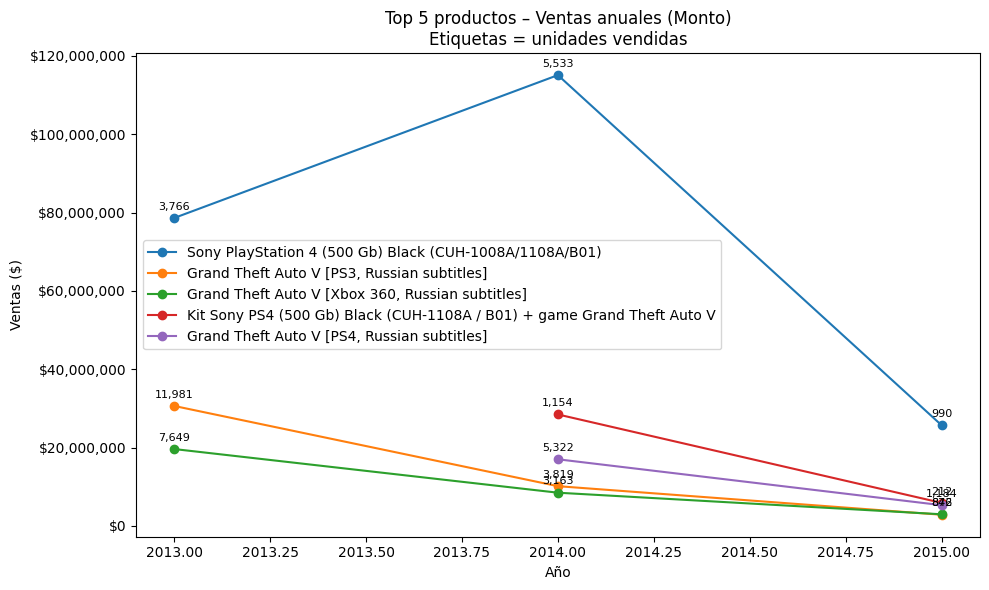

In [148]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

plt.figure(figsize=(10, 6))

for name in top5_yearly_amt["item_name"].unique():
    d = top5_yearly_amt[top5_yearly_amt["item_name"] == name]
    
    # Línea de ventas en monto
    plt.plot(d["year"], d["yearly_sales"], marker="o", label=name)
    
    #  Etiquetas con número de casos (unidades)
    for x, y, units in zip(d["year"], d["yearly_sales"], d["yearly_units"]):
        plt.annotate(
            f"{int(units):,}",   # formato miles
            (x, y),
            textcoords="offset points",
            xytext=(0, 6),
            ha="center",
            fontsize=8
        )

# Formato dólares en eje Y
plt.gca().yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f"${x:,.0f}")
)

plt.title("Top 5 productos – Ventas anuales (Monto)\nEtiquetas = unidades vendidas")
plt.xlabel("Año")
plt.ylabel("Ventas ($)")
plt.legend()
plt.tight_layout()
plt.show()

In [163]:
# Ventas totales por producto

product_sales = (
    df
    .groupby(["item_id", "item_name"], as_index=False)
    .agg(total_sales=("sales", "sum"))
    .sort_values("total_sales", ascending=False)
)
#product_sales.head()

In [165]:
# Total ventas de todos los productos
total_sales_all = product_sales["total_sales"].sum()

product_sales["sales_pct"] = product_sales["total_sales"] / total_sales_all * 100
product_sales["sales_pct_cum"] = product_sales["sales_pct"].cumsum()

product_sales.head(10)

,item_id,item_name,total_sales,sales_pct,sales_pct_cum
6543,6675,Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1...,2.193915e+08,6.454729,6.454729
3654,3732,"Grand Theft Auto V [PS3, Russian subtitles]",4.361798e+07,1.283287,7.738016
13195,13443,Kit Sony PS4 (500 Gb) Black (CUH-1108A / B01) ...,3.433125e+07,1.010061,8.748077
3656,3734,"Grand Theft Auto V [Xbox 360, Russian subtitles]",3.106516e+07,0.913970,9.662047
3655,3733,"Grand Theft Auto V [PS4, Russian subtitles]",2.229886e+07,0.656056,10.318103
16493,16787,"Some of us [PS3, Russian version]",2.190784e+07,0.644552,10.962655
3653,3731,"Grand Theft Auto V [PC, Russian subtitles]",1.998348e+07,0.587935,11.550590
13157,13405,"Комплект ""Microsoft Xbox One 500GB (Day One Ed...",1.812548e+07,0.533271,12.083861
17418,17717,Receiving cash for 1C-line,1.720083e+07,0.506066,12.589927
5718,5823,Playstation Store replenishment wallet: Card P...,1.715185e+07,0.504625,13.094553


In [168]:
# Preparamos el 80%
pareto_80 = product_sales[product_sales["sales_pct_cum"] <= 80]

len(pareto_80), pareto_80.tail(1)

(1672,
        item_id                     item_name  total_sales  sales_pct  \
 14968    15240  Toy Adventure Time Finn 29cm    305158.07   0.008978   
 
        sales_pct_cum  
 14968      79.997931  )

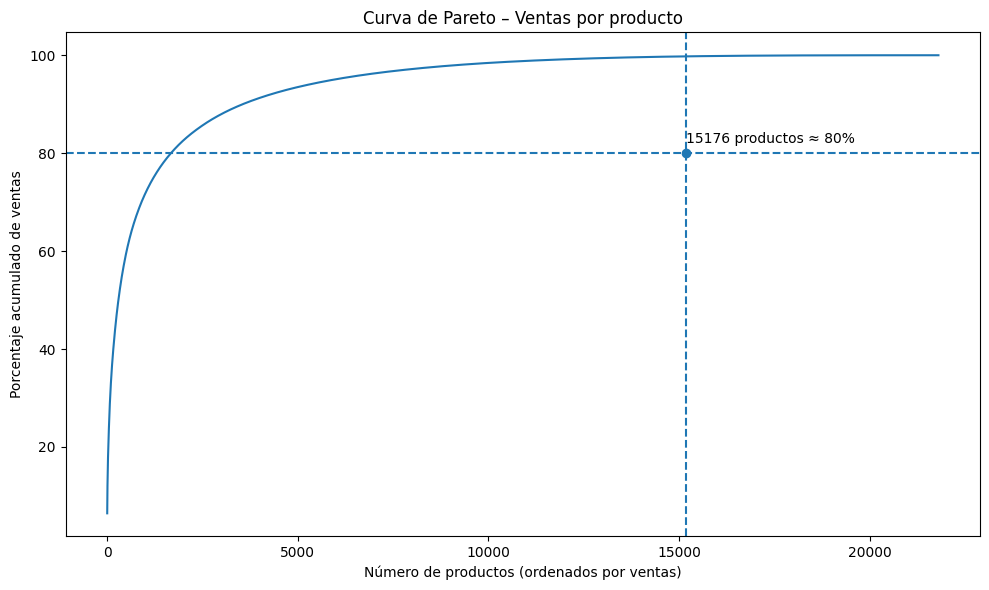

In [169]:
# Graficamos 

import matplotlib.pyplot as plt

# índice del primer producto que supera el 80%
idx_80 = product_sales[product_sales["sales_pct_cum"] >= 80].index[0]
x_80 = idx_80 + 1
y_80 = product_sales.loc[idx_80, "sales_pct_cum"]

plt.figure(figsize=(10, 6))

plt.plot(
    range(1, len(product_sales) + 1),
    product_sales["sales_pct_cum"]
)

plt.axhline(80, linestyle="--")
plt.axvline(x_80, linestyle="--")

plt.scatter(x_80, y_80)
plt.text(x_80, y_80 + 2, f"{x_80} productos ≈ 80%")

plt.xlabel("Número de productos (ordenados por ventas)")
plt.ylabel("Porcentaje acumulado de ventas")
plt.title("Curva de Pareto – Ventas por producto")
plt.tight_layout()
plt.show()

In [194]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from pandas.tseries.offsets import DateOffset

# Asegurar fecha
df["date"] = pd.to_datetime(df["date"], errors="coerce")

# Mes
df["month"] = df["date"].dt.month

# Rango últimos 3 años
max_date = df["date"].max()
min_date = max_date - DateOffset(years=3)

df_3y = df[df["date"].between(min_date, max_date)].copy()

min_date, max_date

(Timestamp('2012-10-31 00:00:00'), Timestamp('2015-10-31 00:00:00'))

In [186]:
import pandas as pd

df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month

from pandas.tseries.offsets import DateOffset

max_date = df["date"].max()
min_date = max_date - DateOffset(years=3)

df_3y = df[df["date"].between(min_date, max_date)].copy()

df_3y.shape

(2935849, 13)

In [187]:
top5_ids = (
    df.groupby(["item_id", "item_name"], as_index=False)
      .agg(total_sales=("sales", "sum"))
      .sort_values("total_sales", ascending=False)
      .head(5)["item_id"]
      .tolist()
)

top5_ids


[6675, 3732, 13443, 3734, 3733]

In [190]:
seasonality_top5_3y = (
    df_3y[df_3y["item_id"].isin(top5_ids)]
    .groupby(["item_id", "item_name", "month"], as_index=False)
    .agg(avg_monthly_sales=("sales", "mean"))
)

# seasonality_top5_3y.head()

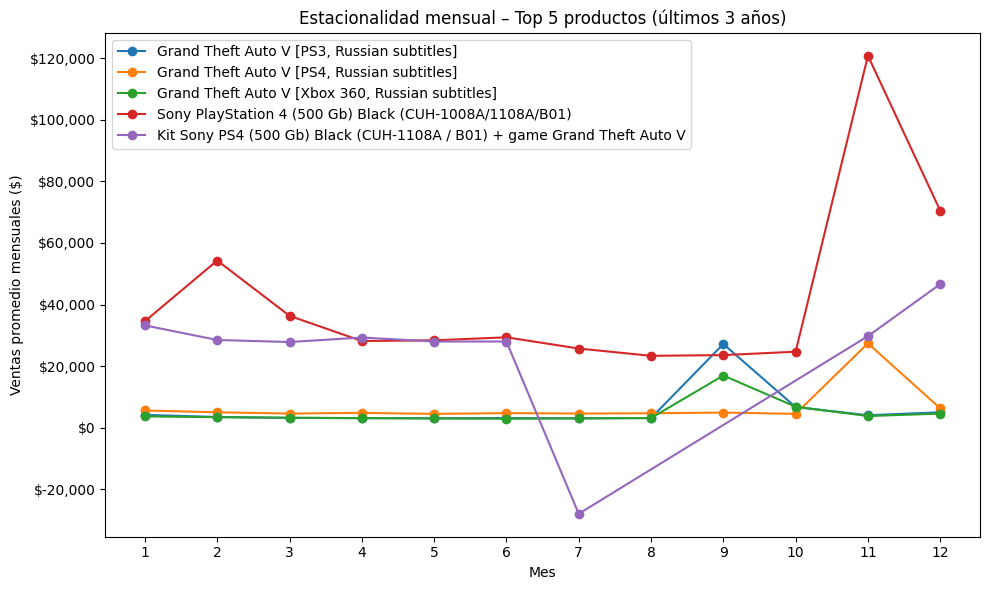

In [191]:
# IDs de los Top 5 productos
plt.figure(figsize=(10, 6))

for name in seasonality_top5_3y["item_name"].unique():
    d = seasonality_top5_3y[seasonality_top5_3y["item_name"] == name]
    plt.plot(d["month"], d["avg_monthly_sales"], marker="o", label=name)

# Formato dólares
plt.gca().yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f"${x:,.0f}")
)

plt.xticks(range(1, 13))
plt.xlabel("Mes")
plt.ylabel("Ventas promedio mensuales ($)")
plt.title("Estacionalidad mensual – Top 5 productos (últimos 3 años)")
plt.legend()
plt.tight_layout()
plt.show()

In [192]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from pandas.tseries.offsets import DateOffset

# Asegurar fecha
df["date"] = pd.to_datetime(df["date"], errors="coerce")

# Año y mes
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month

# Filtrar últimos 3 años
max_date = df["date"].max()
min_date = max_date - DateOffset(years=3)

df_3y = df[df["date"].between(min_date, max_date)].copy
type(df_3y), df_3y

(method,
 <bound method NDFrame.copy of               date  date_block_num  shop_id  item_id  item_price  \
 0       2013-01-02               0       59    22154      999.00   
 1       2013-01-03               0       25     2552      899.00   
 2       2013-01-05               0       25     2552      899.00   
 3       2013-01-06               0       25     2554     1709.05   
 4       2013-01-15               0       25     2555     1099.00   
 ...            ...             ...      ...      ...         ...   
 2935844 2015-10-10              33       25     7409      299.00   
 2935845 2015-10-09              33       25     7460      299.00   
 2935846 2015-10-14              33       25     7459      349.00   
 2935847 2015-10-22              33       25     7440      299.00   
 2935848 2015-10-03              33       25     7460      299.00   
 
          item_cnt_day                                          item_name  \
 0                 1.0                                

In [193]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Asegurar fecha
df["date"] = pd.to_datetime(df["date"], errors="coerce")

# Agregación mensual (TODOS los productos)
monthly_sales_all = (
    df
    .groupby(pd.Grouper(key="date", freq="ME"), as_index=False)
    .agg(total_sales=("sales", "sum"))
)

monthly_sales_all.head()

,date,total_sales
0,2013-01-31,9.194709e+07
1,2013-02-28,9.066571e+07
2,2013-03-31,1.049327e+08
3,2013-04-30,6.915429e+07
4,2013-05-31,6.506531e+07


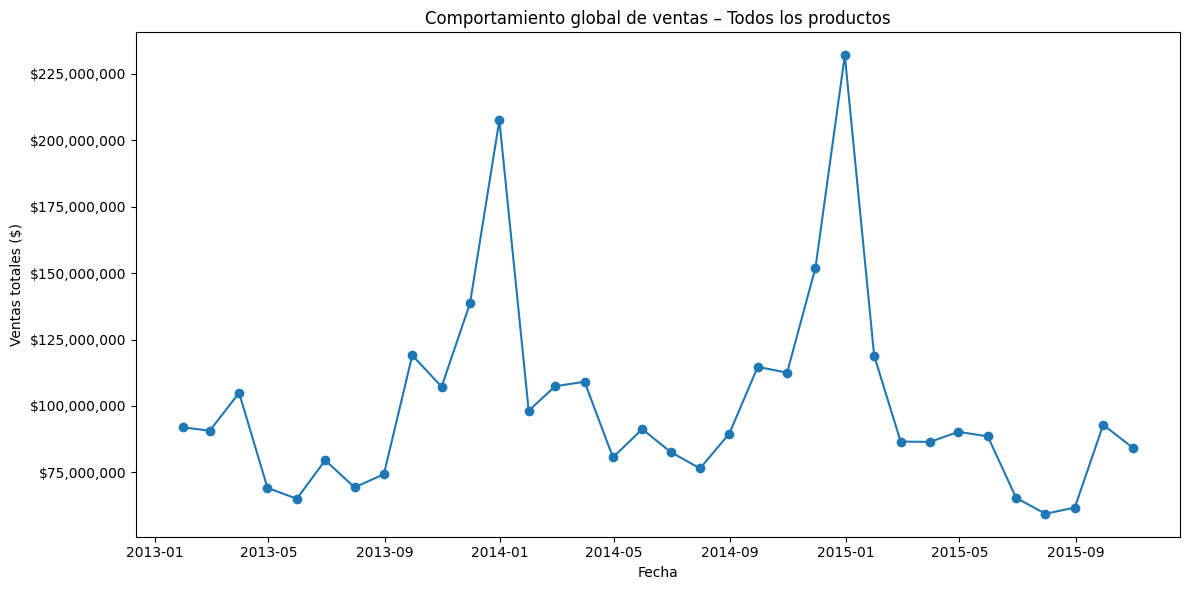

In [76]:
plt.figure(figsize=(12, 6))

plt.plot(
    monthly_sales_all["date"],
    monthly_sales_all["total_sales"],
    marker="o"
)

plt.gca().yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f"${x:,.0f}")
)

plt.title("Comportamiento global de ventas – Todos los productos")
plt.xlabel("Fecha")
plt.ylabel("Ventas totales ($)")
plt.tight_layout()
plt.show()

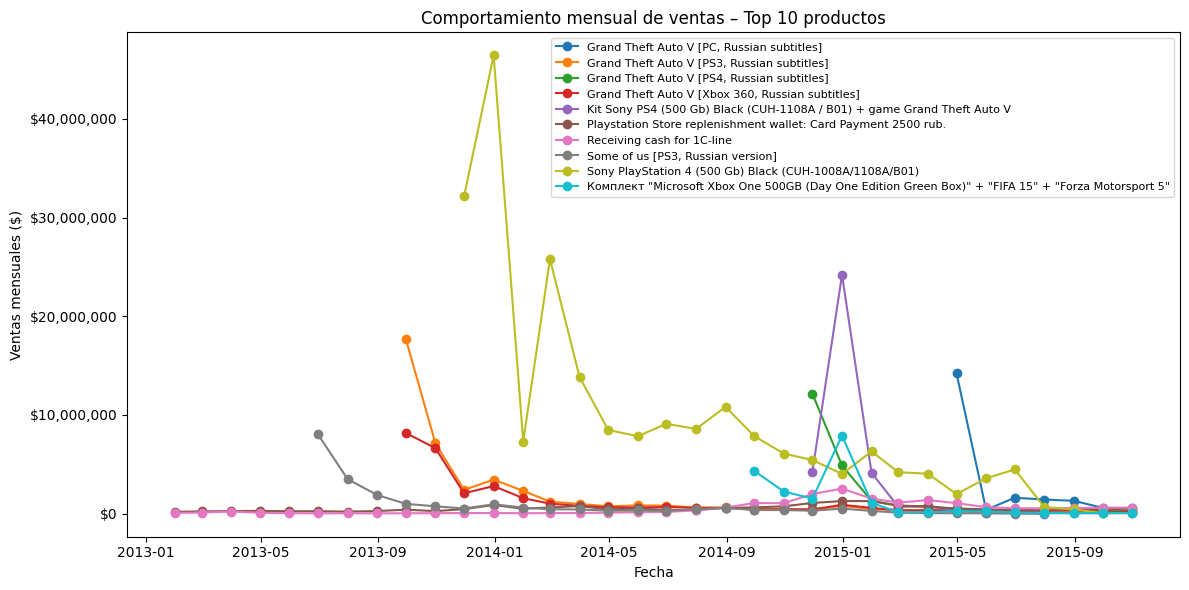

In [177]:
import pandas as pd

df["date"] = pd.to_datetime(df["date"], errors="coerce")

top_n = 10
top_items = (
    df.groupby(["item_id", "item_name"], as_index=False)
      .agg(total_sales=("sales", "sum"))
      .sort_values("total_sales", ascending=False)
      .head(top_n)
)

top_ids = top_items["item_id"].tolist()
top_items

monthly_by_item = (
    df[df["item_id"].isin(top_ids)]
    .groupby([pd.Grouper(key="date", freq="ME"), "item_id", "item_name"], as_index=False)
    .agg(monthly_sales=("sales", "sum"))
    .sort_values(["item_name", "date"])
)

monthly_by_item.head()

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

plt.figure(figsize=(12, 6))

for name in monthly_by_item["item_name"].unique():
    d = monthly_by_item[monthly_by_item["item_name"] == name]
    plt.plot(d["date"], d["monthly_sales"], marker="o", label=name)

plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"${x:,.0f}"))

plt.title("Comportamiento mensual de ventas – Top 10 productos")
plt.xlabel("Fecha")
plt.ylabel("Ventas mensuales ($)")
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()


In [178]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Asegurar fecha
df["date"] = pd.to_datetime(df["date"], errors="coerce")

# Año y mes
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month

# Ventas mensuales por año
monthly_year_sales = (
    df
    .groupby([pd.Grouper(key="date", freq="ME"), "year"], as_index=False)
    .agg(total_sales=("sales", "sum"))
)

monthly_year_sales.head()

,date,year,total_sales
0,2013-01-31,2013,9.194709e+07
1,2013-02-28,2013,9.066571e+07
2,2013-03-31,2013,1.049327e+08
3,2013-04-30,2013,6.915429e+07
4,2013-05-31,2013,6.506531e+07


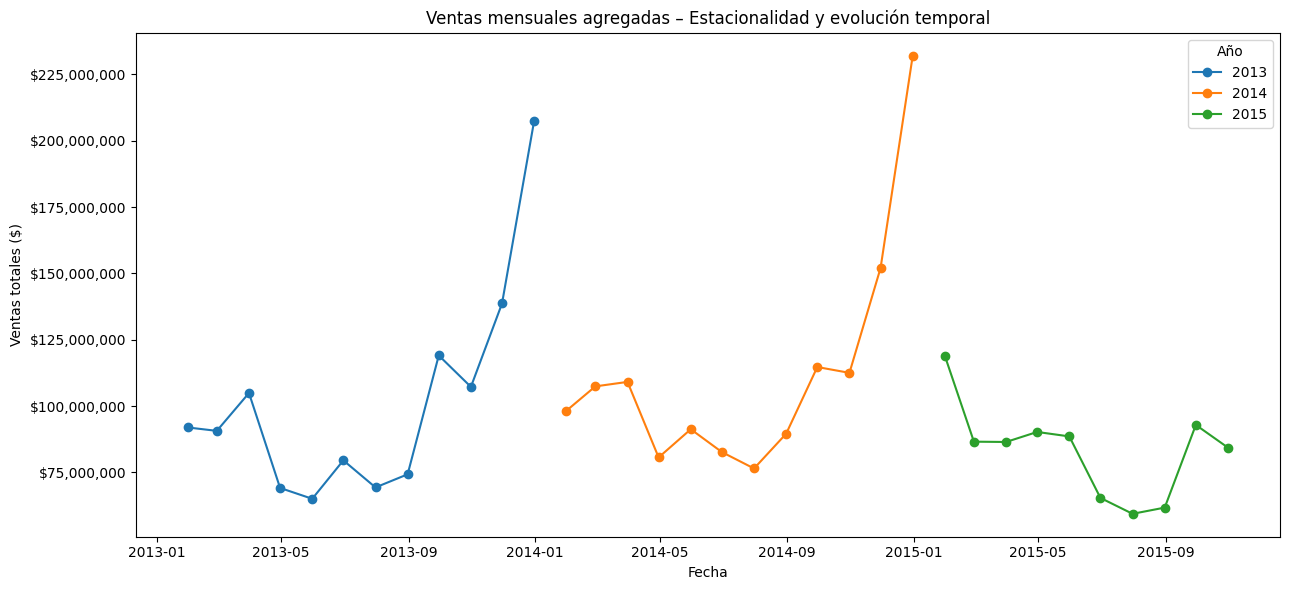

In [179]:
plt.figure(figsize=(13, 6))

for yr in sorted(monthly_year_sales["year"].unique()):
    d = monthly_year_sales[monthly_year_sales["year"] == yr]
    plt.plot(
        d["date"],
        d["total_sales"],
        marker="o",
        label=str(yr)
    )

# Formato dólares
plt.gca().yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f"${x:,.0f}")
)

plt.title("Ventas mensuales agregadas – Estacionalidad y evolución temporal")
plt.xlabel("Fecha")
plt.ylabel("Ventas totales ($)")
plt.legend(title="Año")
plt.tight_layout()
plt.show()

In [195]:
import pandas as pd
import matplotlib.pyplot as plt

# Distribución de tiendas por ubicación
shops_sales = (
    df
    .groupby(["shop_id", "shop_name"], as_index=False)
    .agg(total_sales=("sales", "sum"))
    .sort_values("total_sales", ascending=False)
)

shops_sales.head(15)

,shop_id,shop_name,total_sales
31,31,"Moscow shopping center ""Semyonov""",2.352170e+08
25,25,"Moscow TRC ""Atrium""",2.164806e+08
28,28,"Moscow shopping center ""MEGA Teply Stan"" II of",1.597463e+08
42,42,"St. Petersburg TK ""Nevsky Center""",1.519170e+08
54,54,"Khimki TC ""Mega""",1.419397e+08
27,27,"Moscow shopping center ""MEGA Belaya Dacha II""",1.406325e+08
57,57,"Yakutsk Ordzhonikidze, 56",1.129998e+08
12,12,Shop Online Emergencies,1.122051e+08
6,6,"Voronezh (Plekhanovskaya, 13)",9.806745e+07
18,18,"Krasnoyarsk SC ""June""",8.339270e+07


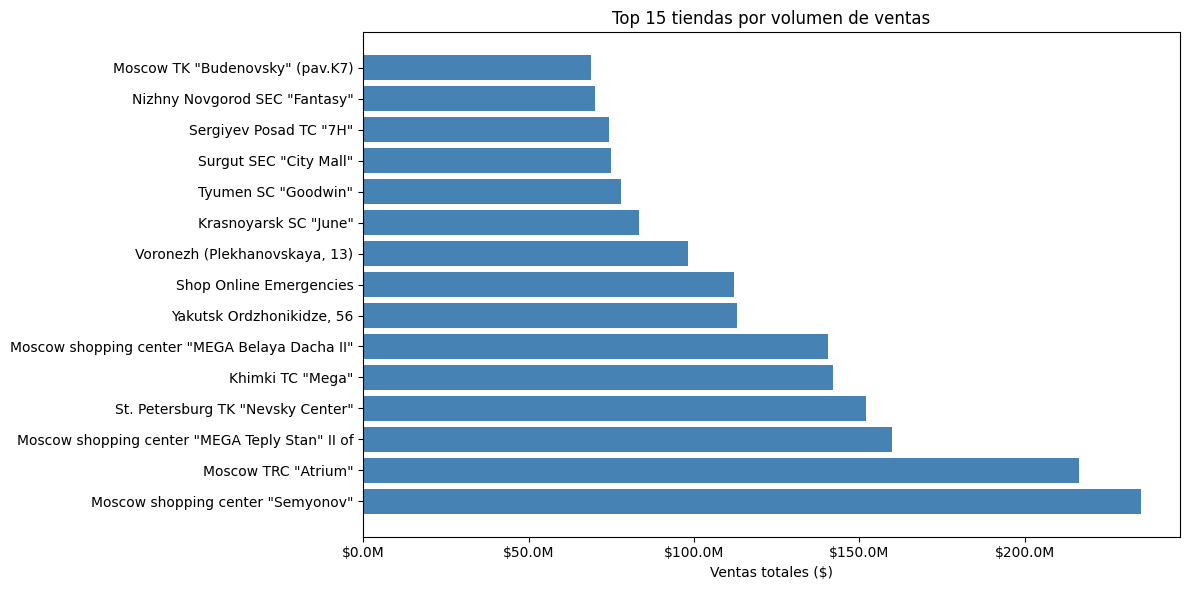

In [199]:
# Gráfico: Top 15 tiendas por ventas totales
from matplotlib.ticker import FuncFormatter

plt.figure(figsize=(12, 6))

# Tomar top 15
top15_shops = shops_sales.head(15)

plt.barh(range(len(top15_shops)), top15_shops["total_sales"], color="steelblue")

plt.yticks(range(len(top15_shops)), top15_shops["shop_name"])
plt.gca().xaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f"${x/1e6:,.1f}M")
)

plt.xlabel("Ventas totales ($)")
plt.title("Top 15 tiendas por volumen de ventas")
plt.tight_layout()
plt.show()

In [205]:
# Distribución geográfica: contar tiendas totales
total_shops = df["shop_id"].nunique()
shops_by_location = (
    df
    .groupby(["shop_id", "shop_name"], as_index=False)
    .agg(num_transactions=("sales", "count"))
)

print(f"Total tiendas únicas: {total_shops}")
print(f"\nVentas por tienda (estadísticas):")
print(shops_sales["total_sales"].describe())

Total tiendas únicas: 60

Ventas por tienda (estadísticas):
count    6.000000e+01
mean     5.664877e+07
std      4.980297e+07
min      3.777140e+05
25%      1.995826e+07
50%      4.671987e+07
75%      6.875614e+07
max      2.352170e+08
Name: total_sales, dtype: float64


In [201]:
# Análisis de concentración: Pareto de tiendas
total_shop_sales = shops_sales["total_sales"].sum()
shops_sales["sales_pct"] = shops_sales["total_sales"] / total_shop_sales * 100
shops_sales["sales_pct_cum"] = shops_sales["sales_pct"].cumsum()

# ¿Cuántas tiendas generan el 80%?
shops_80 = shops_sales[shops_sales["sales_pct_cum"] <= 80]
num_shops_80 = len(shops_80) + 1

print(f"Tiendas para llegar a 80% de ventas: {num_shops_80} de {total_shops}")
print(f"Porcentaje: {(num_shops_80/total_shops)*100:.1f}%")
print(f"\nTop 5 tiendas representan {shops_sales.head(5)['sales_pct'].sum():.1f}% del total")

Tiendas para llegar a 80% de ventas: 30 de 60
Porcentaje: 50.0%

Top 5 tiendas representan 26.6% del total


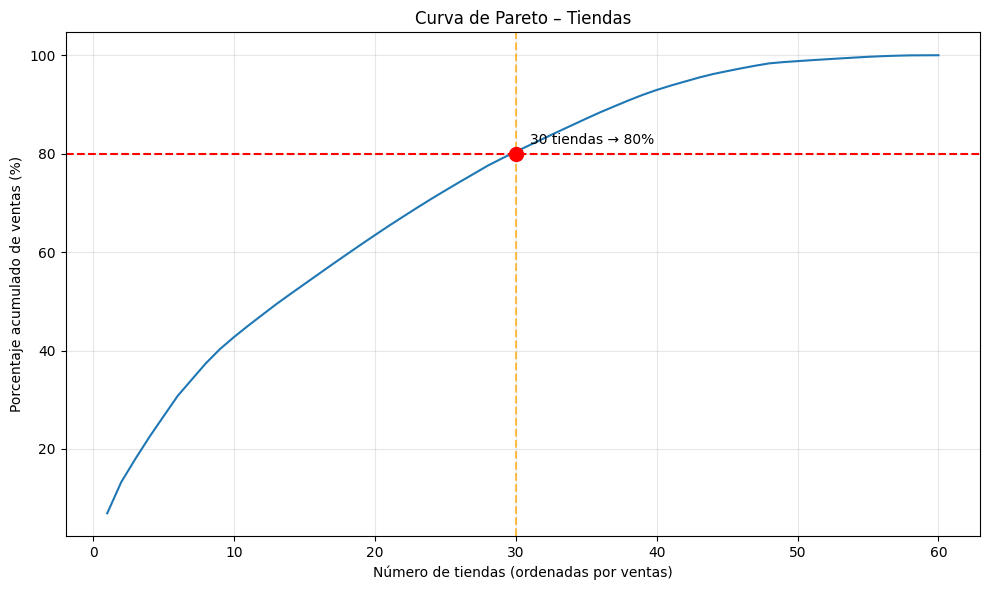

In [203]:
# Gráfico: Curva de Pareto de tiendas
plt.figure(figsize=(10, 6))

plt.plot(
    range(1, len(shops_sales) + 1),
    shops_sales["sales_pct_cum"]
)

# Línea 80%
plt.axhline(80, linestyle="--", color="red", label="80%")
plt.axvline(num_shops_80, linestyle="--", color="orange", alpha=0.7)

plt.scatter(num_shops_80, 80, color="red", s=100, zorder=5)
plt.text(num_shops_80 + 1, 82, f"{num_shops_80} tiendas → 80%", fontsize=10)

plt.xlabel("Número de tiendas (ordenadas por ventas)")
plt.ylabel("Porcentaje acumulado de ventas (%)")
plt.title("Curva de Pareto – Tiendas")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

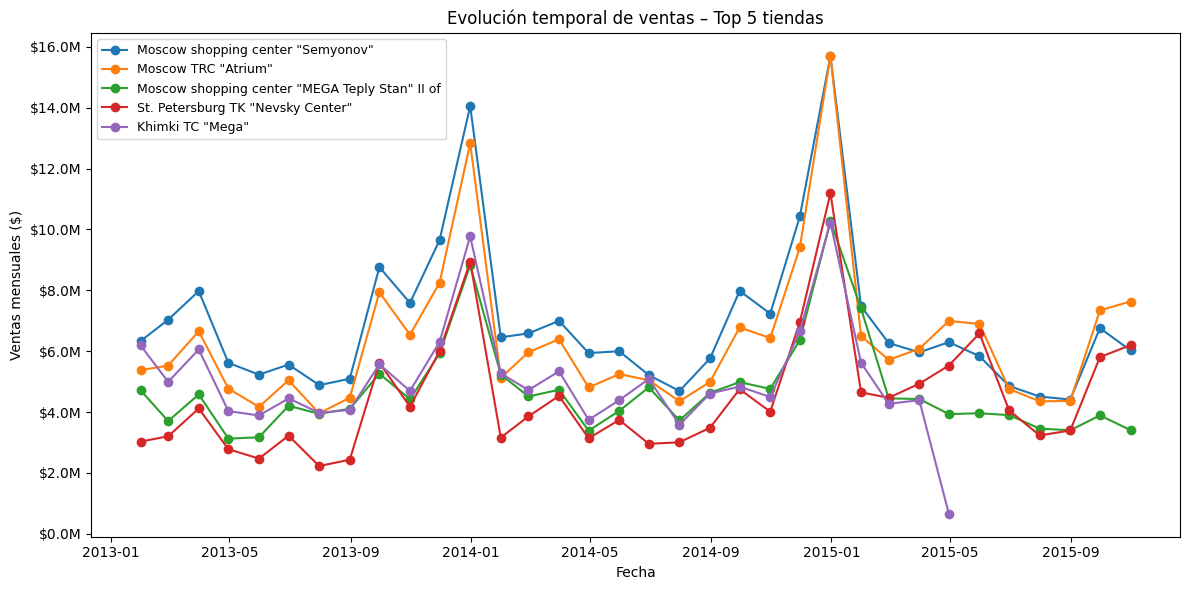

In [204]:
# Evolución temporal de ventas por tienda (Top 5)
top5_shop_ids = shops_sales.head(5)["shop_id"].tolist()
top5_shop_names = shops_sales.head(5)[["shop_id", "shop_name"]].set_index("shop_id")["shop_name"].to_dict()

monthly_by_shop = (
    df[df["shop_id"].isin(top5_shop_ids)]
    .groupby([pd.Grouper(key="date", freq="ME"), "shop_id"], as_index=False)
    .agg(monthly_sales=("sales", "sum"))
)

plt.figure(figsize=(12, 6))

for shop_id in top5_shop_ids:
    d = monthly_by_shop[monthly_by_shop["shop_id"] == shop_id]
    plt.plot(
        d["date"],
        d["monthly_sales"],
        marker="o",
        label=top5_shop_names.get(shop_id, f"Shop {shop_id}")
    )

plt.gca().yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f"${x/1e6:,.1f}M")
)

plt.title("Evolución temporal de ventas – Top 5 tiendas")
plt.xlabel("Fecha")
plt.ylabel("Ventas mensuales ($)")
plt.legend(fontsize=9)
plt.tight_layout()
plt.show()

In [211]:
# Estadísticas descriptivas de variables clave
print("=" * 70)
print("ESTADÍSTICAS DESCRIPTIVAS - VARIABLES CLAVE")
print("=" * 70)

# Variables numéricas principales
stats_vars = ["item_price", "item_cnt_day", "sales"]

for var in stats_vars:
    print(f"\n### {var.upper()} ###")
    print(df[var].describe())
    print(f"Asimetría (Skewness): {df[var].skew():.4f}")
    print(f"Curtosis (Kurtosis): {df[var].kurtosis():.4f}")
    print(f"Coef. Variación: {(df[var].std() / df[var].mean()):.4f}")


ESTADÍSTICAS DESCRIPTIVAS - VARIABLES CLAVE

### ITEM_PRICE ###
count    2.935849e+06
mean     8.908532e+02
std      1.729800e+03
min     -1.000000e+00
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
max      3.079800e+05
Name: item_price, dtype: float64
Asimetría (Skewness): 10.7504
Curtosis (Kurtosis): 445.5328
Coef. Variación: 1.9417

### ITEM_CNT_DAY ###
count    2.935849e+06
mean     1.242641e+00
std      2.618834e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.169000e+03
Name: item_cnt_day, dtype: float64
Asimetría (Skewness): 272.8332
Curtosis (Kurtosis): 177478.0988
Coef. Variación: 2.1075

### SALES ###
count    2.935849e+06
mean     1.157732e+03
std      5.683604e+03
min     -6.897000e+04
25%      2.490000e+02
50%      4.490000e+02
75%      1.078200e+03
max      1.829990e+06
Name: sales, dtype: float64
Asimetría (Skewness): 103.5591
Curtosis (Kurtosis): 19734.5477
Coef. Variación: 4.9093


In [212]:
# Análisis de datos faltantes y valores atípicos
print("\n" + "=" * 70)
print("DATOS FALTANTES Y OUTLIERS")
print("=" * 70)

print(f"\nDatos faltantes (NaN):")
print(df[["item_price", "item_cnt_day", "sales"]].isnull().sum())

# Detectar outliers con IQR
def outlier_count(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return ((series < lower) | (series > upper)).sum()

print(f"\nOutliers detectados (método IQR):")
print(f"item_price: {outlier_count(df['item_price'])} ({outlier_count(df['item_price'])/len(df)*100:.2f}%)")
print(f"item_cnt_day: {outlier_count(df['item_cnt_day'])} ({outlier_count(df['item_cnt_day'])/len(df)*100:.2f}%)")
print(f"sales: {outlier_count(df['sales'])} ({outlier_count(df['sales'])/len(df)*100:.2f}%)")


DATOS FALTANTES Y OUTLIERS

Datos faltantes (NaN):
item_price      0
item_cnt_day    0
sales           0
dtype: int64

Outliers detectados (método IQR):
item_price: 258942 (8.82%)
item_cnt_day: 306477 (10.44%)
sales: 297251 (10.12%)


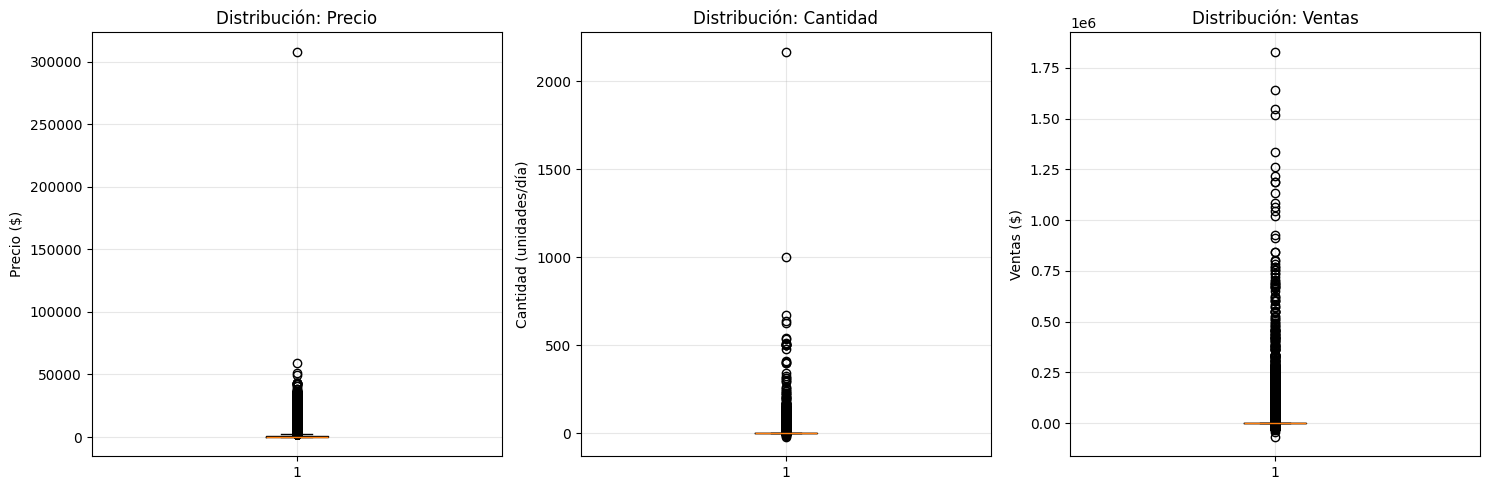

In [213]:
# Box plots para visualizar distribuciones y outliers
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Box plot para cada variable
axes[0].boxplot(df["item_price"], vert=True)
axes[0].set_ylabel("Precio ($)")
axes[0].set_title("Distribución: Precio")
axes[0].grid(True, alpha=0.3)

axes[1].boxplot(df["item_cnt_day"], vert=True)
axes[1].set_ylabel("Cantidad (unidades/día)")
axes[1].set_title("Distribución: Cantidad")
axes[1].grid(True, alpha=0.3)

axes[2].boxplot(df["sales"], vert=True)
axes[2].set_ylabel("Ventas ($)")
axes[2].set_title("Distribución: Ventas")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()